In [8]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import statsmodels.api as sm
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from xgboost import XGBRegressor 

In [9]:
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

In [32]:
import os

In [12]:
# arn:aws:s3:::sales-forecasting-dataset

# Read files



bucket = "sales-forecasting-dataset"
client = boto3.client('s3') #low-level functional API
resource = boto3.resource('s3') #high-level object-oriented API
obj = client.get_object(Bucket=bucket, Key='train.csv')
train = pd.read_csv(obj['Body'])

In [6]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [25]:
obj = client.get_object(Bucket=bucket, Key='test.csv')
test = pd.read_csv(obj['Body'])
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


### Pre processing

In [7]:
from datetime import date, timedelta

sdate = date(2013, 1, 1)   # start date
edate = date(2017, 12, 31)   # end date

delta = edate - sdate       # as timedelta
days=[]

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    days.append(day)

all_days=[str(i) for i in days]


In [8]:
t = 0
for i in range(1,51):
    for j in range(1,11):
        date = list(train[(train["item"]==i)&(train["store"]==j)]["date"])
        if(date==all_days): t=t+1
print(t) # check whether how many have incomplete data

500


### Checking the trend and seasonality

<Figure size 432x288 with 0 Axes>

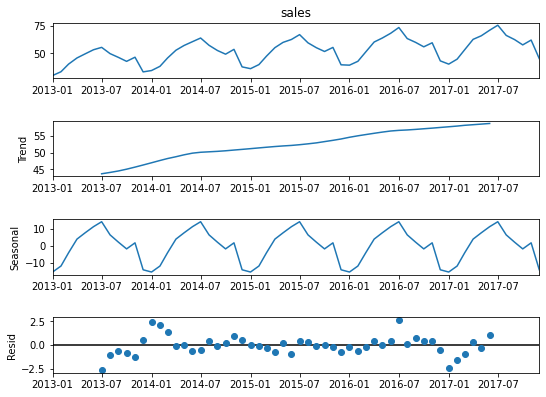

In [13]:
train["date"] = train["date"].apply(lambda x: dt.strptime(str(x), '%Y-%m-%d'))
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

### check outliers

In [14]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit,quartile1,quartile3

def check_outlier(dataframe, col_name, q1_perc=0.09, q3_perc=0.91):
    outlier_list = []
    low_limit, up_limit,quartile1,quartile3 = outlier_thresholds(dataframe, col_name, q1_perc, q3_perc)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return low_limit, up_limit,quartile1,quartile3

    else:
        return False

In [15]:
outlier = check_outlier(train, 'sales')
outlier

(-95.0, 209.0, 19.0, 95.0)

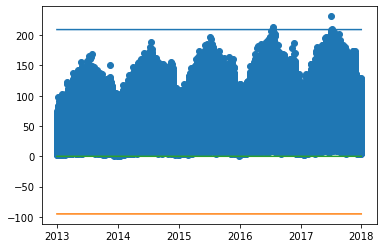

In [16]:
if(outlier):
    plt.scatter(train["date"],train["sales"])
    plt.plot(train["date"],[outlier[1]]*len(train["date"]))
    plt.plot(train["date"],[outlier[0]]*len(train["date"]))
    plt.plot(train["date"],[min(train["sales"])]*len(train["date"]))
else:
    plt.scatter(train["date"],train["sales"])

In [17]:
if(outlier):
    train = train[(train["sales"]>=outlier[0])&(train["sales"]<=outlier[1])]

### Date Created

In [18]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    return df

df = create_date_features(train)
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,2013-01-01,1,1,13,1,1,1,1,2,2013,0
1,2013-01-02,1,1,11,1,2,2,1,3,2013,0
2,2013-01-03,1,1,14,1,3,3,1,4,2013,0
3,2013-01-04,1,1,13,1,4,4,1,5,2013,1
4,2013-01-05,1,1,10,1,5,5,1,6,2013,1


### Creating lag feature

In [21]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag)) 
    return dataframe

df = lag_features(df, [182, 364, 546, 728])
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
912995,2017-12-27,10,50,63,12,27,361,52,3,2017,0,91.0,43.0,80.0,51.0
912996,2017-12-28,10,50,59,12,28,362,52,4,2017,0,122.0,68.0,91.0,44.0
912997,2017-12-29,10,50,74,12,29,363,52,5,2017,1,112.0,63.0,101.0,59.0
912998,2017-12-30,10,50,62,12,30,364,52,6,2017,1,119.0,64.0,113.0,63.0
912999,2017-12-31,10,50,82,12,31,365,52,7,2017,1,120.0,69.0,123.0,81.0


### roll_mean_features

In [23]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) 
    return dataframe
df = roll_mean_features(df, [365, 546, 730])
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
912995,2017-12-27,10,50,63,12,27,361,52,3,2017,0,91.0,43.0,80.0,51.0,90.758219,82.243100,81.855493
912996,2017-12-28,10,50,59,12,28,362,52,4,2017,0,122.0,68.0,91.0,44.0,90.802383,82.284889,81.862057
912997,2017-12-29,10,50,74,12,29,363,52,5,2017,1,112.0,63.0,101.0,59.0,90.844665,82.326752,81.868632
912998,2017-12-30,10,50,62,12,30,364,52,6,2017,1,119.0,64.0,113.0,63.0,90.883156,82.368957,81.875234
912999,2017-12-31,10,50,82,12,31,365,52,7,2017,1,120.0,69.0,123.0,81.0,90.918839,82.411229,81.881719


In [28]:
cols = list(train)
cols.insert(0, cols.pop(cols.index('sales')))
train = train.loc[:, cols]

In [67]:
train

,sales,date,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,13,2013-01-01,1,1,1,1,1,1,2,2013,0
1,11,2013-01-02,1,1,1,2,2,1,3,2013,0
2,14,2013-01-03,1,1,1,3,3,1,4,2013,0
3,13,2013-01-04,1,1,1,4,4,1,5,2013,1
4,10,2013-01-05,1,1,1,5,5,1,6,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
182493,63,2017-12-27,10,50,12,27,361,52,3,2017,0
182494,59,2017-12-28,10,50,12,28,362,52,4,2017,0
182495,74,2017-12-29,10,50,12,29,363,52,5,2017,1
182496,62,2017-12-30,10,50,12,30,364,52,6,2017,1


In [68]:
train_data = train[train["year"]<2016]
validation_data = train[train["year"]==2016]
test_data = train[train["year"]==2017]

In [69]:
train_data.to_csv('train.csv',header=True,index=False)
validation_data.to_csv('validation.csv',header=True,index=False)
test_data.to_csv('test.csv',header=True,index=False)

In [70]:
prefix = "XGBoost"
bucket = "sales-forecasting-dataset"


In [71]:
role = get_execution_role()            ## Run this before the training job to get your IAM role
region = boto3.Session().region_name   ## Run this here, you will need it during training

## Uploads training and validation csv for XGBoost to train on
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('XGBoost/train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('XGBoost/validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('XGBoost/test/test.csv')).upload_file('test.csv')

In [72]:
x_train = train_data[[col for col in train_data.columns if col not in ["date","sales",'Unnamed: 0']]]
x_validation = validation_data[[col for col in validation_data.columns if col not in ["date","sales",'Unnamed: 0']]]

y_train = train_data["sales"]
y_validation = validation_data["sales"]


In [73]:
regressor = XGBRegressor(max_depth=6,eta=0.01)
regressor.fit(x_train, y_train.ravel())

y_pred_val = regressor.predict(x_validation)
#mean_absolute_percentage_error(np.expm1(y_pred_val), np.expm1(Y_val))
mean_absolute_percentage_error(y_pred_val, y_validation)

[18:02:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1721758981234315

In [ ]:
#0.1525361668875192

In [74]:
train_data

,sales,date,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,13,2013-01-01,1,1,1,1,1,1,2,2013,0
1,11,2013-01-02,1,1,1,2,2,1,3,2013,0
2,14,2013-01-03,1,1,1,3,3,1,4,2013,0
3,13,2013-01-04,1,1,1,4,4,1,5,2013,1
4,10,2013-01-05,1,1,1,5,5,1,6,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
730128,57,2015-12-27,10,50,12,27,361,52,7,2015,1
730129,42,2015-12-28,10,50,12,28,362,53,1,2015,0
730130,45,2015-12-29,10,50,12,29,363,53,2,2015,0
730131,51,2015-12-30,10,50,12,30,364,53,3,2015,0


In [75]:

s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [76]:
sess = sagemaker.Session()
region = boto3.Session().region_name
role = get_execution_role() 
container = get_image_uri(region, 'xgboost',repo_version='1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess,
                                    train_use_spot_instances=True,
                                    train_max_run=300,
                                    train_max_wait=600)

xgb.set_hyperparameters(max_depth=6,
                        eta=0.01,
                        silent=0,
                        objective="reg:linear",
                        num_round=100,
                        eval_metric='map')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-01-04 18:09:15 Starting - Starting the training job...
2022-01-04 18:09:38 Starting - Launching requested ML instancesProfilerReport-1641319754: InProgress
...
2022-01-04 18:10:09 Starting - Preparing the instances for training...............
2022-01-04 18:12:41 Downloading - Downloading input data...
2022-01-04 18:12:59 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','


In [77]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

------!

In [89]:
from sagemaker.deserializers import PandasDeserializer
from sagemaker.serializers import JSONSerializer


class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {'instances': []}
        for row in data:
            js['instances'].append({'features': row.tolist()})
        return json.dumps(js)


predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=FMSerializer(),
    deserializer=PandasDeserializer()
)

------!

In [87]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [43]:
x_test = test_data[[col for col in test_data.columns if col not in ["date","sales",'Unnamed: 0']]]
y_test = test_data["sales"]
x_test

,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,1,1,1,1,1,52,7,2017,1
1,1,1,1,2,2,1,1,2017,0
2,1,1,1,3,3,1,2,2017,0
3,1,1,1,4,4,1,3,2017,0
4,1,1,1,5,5,1,4,2017,0
...,...,...,...,...,...,...,...,...,...
182493,10,50,12,27,361,52,3,2017,0
182494,10,50,12,28,362,52,4,2017,0
182495,10,50,12,29,363,52,5,2017,1
182496,10,50,12,30,364,52,6,2017,1


In [51]:
xt = np.array(x_test.values, dtype=np.float32)
xt

array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 7.000e+00, 2.017e+03,
        1.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 2.017e+03,
        0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 2.000e+00, 2.017e+03,
        0.000e+00],
       ...,
       [1.000e+01, 5.000e+01, 1.200e+01, ..., 5.000e+00, 2.017e+03,
        1.000e+00],
       [1.000e+01, 5.000e+01, 1.200e+01, ..., 6.000e+00, 2.017e+03,
        1.000e+00],
       [1.000e+01, 5.000e+01, 1.200e+01, ..., 7.000e+00, 2.017e+03,
        1.000e+00]], dtype=float32)

In [53]:
x_test

,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,1,1,1,1,1,52,7,2017,1
1,1,1,1,2,2,1,1,2017,0
2,1,1,1,3,3,1,2,2017,0
3,1,1,1,4,4,1,3,2017,0
4,1,1,1,5,5,1,4,2017,0
...,...,...,...,...,...,...,...,...,...
182493,10,50,12,27,361,52,3,2017,0
182494,10,50,12,28,362,52,4,2017,0
182495,10,50,12,29,363,52,5,2017,1
182496,10,50,12,30,364,52,6,2017,1


In [55]:
def predict(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')


In [79]:
test_data

,sales,date,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd
0,19,2017-01-01,1,1,1,1,1,52,7,2017,1
1,15,2017-01-02,1,1,1,2,2,1,1,2017,0
2,10,2017-01-03,1,1,1,3,3,1,2,2017,0
3,16,2017-01-04,1,1,1,4,4,1,3,2017,0
4,14,2017-01-05,1,1,1,5,5,1,4,2017,0
...,...,...,...,...,...,...,...,...,...,...,...
182493,63,2017-12-27,10,50,12,27,361,52,3,2017,0
182494,59,2017-12-28,10,50,12,28,362,52,4,2017,0
182495,74,2017-12-29,10,50,12,29,363,52,5,2017,1
182496,62,2017-12-30,10,50,12,30,364,52,6,2017,1


In [91]:
import json

In [92]:
predictor.predict(x_test.values).decode('utf-8')

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Amazon SageMaker could not get a response from the sagemaker-xgboost-2022-01-04-18-54-07-511 endpoint. This can occur when CPU or memory utilization is high. To check your utilization, see Amazon CloudWatch. To fix this problem, use an instance type with more CPU capacity or memory.". See https://ap-southeast-1.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-xgboost-2022-01-04-18-54-07-511 in account 778375262158 for more information.

In [80]:
#TT = pd.read_csv('test.csv')
x_test = test_data[[col for col in test_data.columns if col not in ["date","sales"]]]
y_test = test_data["sales"]


xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


predictions = xgb_predictor.predict(x_test.values).decode('utf-8')
predictions_test = np.fromstring(predictions[1:], sep=',')
mean_absolute_percentage_error(predictions_test, y_test)

AttributeError: 'NoneType' object has no attribute 'ACCEPT'

In [3]:
%conda install -c anaconda py-xgboost

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::nbclient==0.5.2=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/linux-64::widgetsnbextension==3.5.1=py36h5fab9bb_4
  - conda-forge/noarch::flake8==3.8.4=py_0
  - conda-forge/noarch::ipywidgets==7.6.3=pyhd3deb0d_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/noarch::path.py==12.5.0=0
  - conda-forge/noarch::dask==2021.2.0=pyhd8ed1ab_0
  - conda-forge/noarch::nbformat==5.1.2=pyhd8ed1ab_1
  - conda-forge/linux-64::path==15.1.2=py36h5fab9bb_0
  - conda-forge/linux-64::nbconvert==6.0.7=py36h5fab9bb_3
  - conda-forge/linux-64::distributed==2021.2.0=py36h5fab9bb_0
  - conda-f